# Model comparison

To demonstrate the use of model comparison criteria in PyMC3, we implement the **8 schools** example from Section 5.5 of Gelman et al (2003), which attempts to infer the effects of coaching on SAT scores of students from 8 schools. Below, we fit a **pooled model**, which assumes a single fixed effect across all schools, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

The data include the observed treatment effects and associated standard deviations in the 8 schools.

In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

### Pooled model

In [3]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sd=1e6)
    
    obs = pm.Normal('obs', mu, sd=sigma, observed=y)
    
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
100%|██████████| 1500/1500 [00:02<00:00, 688.78it/s]


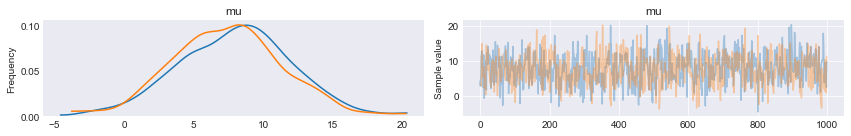

In [4]:
pm.traceplot(trace_p);

### Hierarchical model

In [5]:
with pm.Model() as hierarchical:
    
    eta = pm.Normal('eta', 0, 1, shape=J)
    mu = pm.Normal('mu', 0, sd=1e6)
    tau = pm.HalfCauchy('tau', 5)
    
    theta = pm.Deterministic('theta', mu + tau*eta)
    
    obs = pm.Normal('obs', theta, sd=sigma, observed=y)
    
    trace_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_log__, mu, eta]
 99%|█████████▊| 1478/1500 [00:03<00:00, 455.75it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 1500/1500 [00:04<00:00, 368.24it/s]


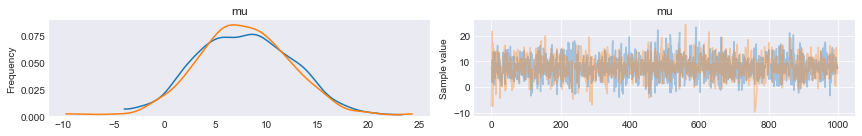

In [6]:
pm.traceplot(trace_h, varnames=['mu']);

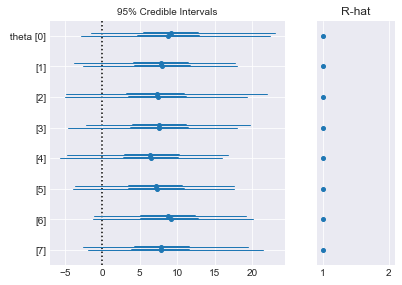

In [7]:
pm.forestplot(trace_h, varnames=['theta']);

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

In [8]:
pooled_waic = pm.waic(trace_p, pooled)
    
pooled_waic.WAIC

60.998741208100945

In [9]:
hierarchical_waic = pm.waic(trace_h, hierarchical)
    
hierarchical_waic.WAIC

61.560009093527142

PyMC3 includes two convenience functions to help compare WAIC for different models. The first of this functions is `compare`, this one computes WAIC (or LOO) from a set of traces and models and returns a DataFrame.

In [10]:
df_comp_WAIC = pm.compare((trace_h, trace_p), (hierarchical, pooled))
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,61,0.62,0,1,2.21,0,1
0,61.56,1.05,0.56,0,2,0.25,1


We have many columns so let check one by one the meaning of them:


1. The first column clearly contains the values of WAIC. The DataFrame is always sorted from lowest to highest WAIC. The index reflects the order in which the models are passed to this function.

2. The second column is the estimated effective number of parameters. In general, models with more parameters will be more flexible to fit data and at the same time could also lead to overfitting. Thus we can interpret pWAIC as a penalization term, intuitively we can also interpret it as measure of how flexible each model is in fitting the data. 

3. The third column is the relative difference between the value of WAIC for the top-ranked model and the value of WAIC for each model. For this reason we will always get a value of 0 for the first model.

4. Sometimes when comparing models, we do not want to select the "best" model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC (i.e. the uncertainty is ignored).

5. The fifth column records the standard error for the WAIC computations. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

6. In the same way that we can compute the standard error for each value of WAIC, we can compute the standard error of the differences between two values of WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

7. Finally we have the last column named "warning". A value of 1 indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution. For more details you can read this [paper](https://arxiv.org/abs/1507.04544).

The second convenience function takes the output of `compare` and produces a summary plot in the style of the one used in the book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath (check also [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3) of the examples in the book to PyMC3).

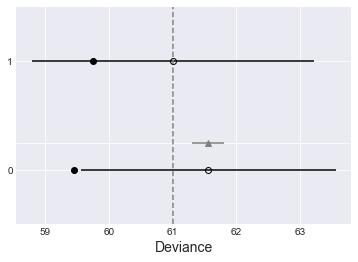

In [11]:
pm.compareplot(df_comp_WAIC);

The empty circle represents the values of WAIC and the black error bars associated with them are the values of the standard deviation of WAIC. 

The value of the lowest WAIC is also indicated with a vertical dashed grey line to ease comparison with other WAIC values.

The filled black dots are the in-sample deviance of each model, which for WAIC is  2 pWAIC from the corresponding WAIC value.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

In [12]:
pooled_loo = pm.loo(trace_p, pooled)
    
pooled_loo.LOO

61.023689092648688

In [13]:
hierarchical_loo  = pm.loo(trace_h, hierarchical)
    
hierarchical_loo.LOO

61.677599215131018

We can also use `compare` with LOO.

In [14]:
df_comp_LOO = pm.compare((trace_h, trace_p), (hierarchical, pooled), ic='LOO')
df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
1,61.02,0.64,0,1,2.21,0,1
0,61.68,1.11,0.65,0,2,0.25,1


The columns return the equivalent values for LOO, notice that in this example we get two warnings. Also notice that the order of the models is not the same as the one for WAIC.

We can also plot the results

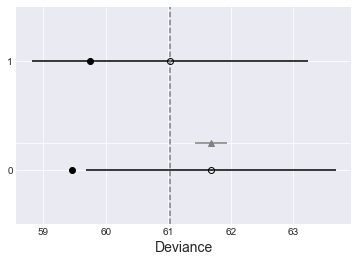

In [15]:
pm.compareplot(df_comp_LOO);

### Interpretation

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, giving that both models gives very similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of WAIC and LOO.

## Reference

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](http://doi.org/10.1007/s11222-013-9416-2)

[Vehtari, A, Gelman, A, Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing](http://link.springer.com/article/10.1007/s11222-016-9696-4)